<div class="usecase-title">Optimising Parking Accessibility Near Healthcare and Educational Facilities in Melbourne</div>

<div class="usecase-authors"><b>Authored by: </b> Nattakan Owatwansakul</div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python, Data cleaning, Data analysis, Data visualisation</div>
</div>

<div class="usecase-section-header">Scenario</div>

As an urban planner in the city of Melbourne, I want to identify areas near healthcare and educational facilities where parking is limited but demand is high, So that I can make informed decisions about improving parking infrastructure and accessibility for patients, students, and staff.

<div class="usecase-section-header">What this use case will teach you</div>


At the end of this use case you will:
- Learn how to import and combine data from various sources.
- Understand relationship between parking demand, pedestrian traffic and public facilities.
- Gain skills in analysing data and presenting data insights for clients

<div class="usecase-section-header">Introduction</div>

In growing cities like Melbourne, healthcare and educational facilities are essential parts of the community and attract high numbers of daily visitors. These places often have a lot of foot traffic, especially during rush hours. However, there is not always enough parking nearby for patients, students, and staff. This can cause inconvinience, delays, and access issues, especially for patients, students, and people who need these services.

This use case aims to explore parking accessibility around healthcare and educational institutions in Melbourne. By analysing data on car park capacity, facility locations, and pedestrian movement, the project seeks to identify areas with high demand but limited parking. The results will support urban planners in making informed decisions to improve parking infrastructure and future city planning.

<div class="usecase-section-header">Datasets</div>

- <strong>[Off-street car parks with capacity and type](https://data.melbourne.vic.gov.au/explore/dataset/off-street-car-parks-with-capacity-and-type/information/)</strong><br>
      Data collected as part of the City of Melbourne's Census of Land Use and Employment (CLUE). The data covers the period 2002-2023.
- <strong>[Landmarks and places of interest, including schools, theatres, health services, sports facilities, places of worship, galleries and museums](https://data.melbourne.vic.gov.au/explore/dataset/landmarks-and-places-of-interest-including-schools-theatres-health-services-spor/information/)</strong><br>
    Dataset contains a description and co-ordinates of places of interest within the City of Melbourne.
- <strong>[Pedestrian Counting System (counts per hour)](https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/information/)</strong><br>
This dataset contains hourly pedestrian counts since 2009 from pedestrian sensor devices located across the city. The data is updated on a monthly basis and can be used to determine variations in pedestrian activity throughout the day.

# Import Libraries

In [5]:
#for using APIs
import requests
#data monipulation and analysis
import pandas as pd
# convert text
from io import StringIO
#calculate distance between two points
from geopy.distance import geodesic
#interactive map
import folium

# Loading data through APIs V2.1 from CoM open data portal

We define a function that connects to the City of Melbourne’s Open Data platform to automatically retrieve datasets relevant to this project. Rather than downloading files manually, this function sends a request to the data portal through a web address (API) and asks for the entire dataset. The data is then converted into a format suitable for analysis in Python, using `pandas`.

This method ensures we are working with the most current and complete data available. In this use case, we use it to load datasets such as landmarks (including schools, libraries, and health services), parking availability, and pedestrian traffic. This approach improves efficiency, keeps the project up to date, and reduces the risk of human error associated with manual downloads.

In [9]:
def API_Unlimited(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    #apikey = 'apikey
    dataset_id = dataset_id
    format = 'csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit': -1,
        'lang': 'en',
        'timezone': 'UTC',
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f'Request failed with status code {response.status_code}')

In [11]:
landmark_location = API_Unlimited('landmarks-and-places-of-interest-including-schools-theatres-health-services-spor')
parking_capacity = API_Unlimited('off-street-car-parks-with-capacity-and-type')
pedestrian_count = API_Unlimited('pedestrian-counting-system-monthly-counts-per-hour')

## Previewing the Raw Datasets
1. The **landmark** dataset contains important public locations across Melbourne, such as schools, health services, and places of worship. It includes columns like `theme`, `sub_theme`, `feature_name`, and `co_ordinates` (latitude and longitude combined). This information helps us later identify which landmarks are near public parking or pedestrian sensors.

In [13]:
landmark_location.head()

,theme,sub_theme,feature_name,co_ordinates
0,Place of Worship,Church,St Francis Church,"-37.8118847831837, 144.962422614541"
1,Place of Worship,Church,St James Church,"-37.8101281201969, 144.952468571683"
2,Place of Worship,Church,St Mary's Anglican Church,"-37.8031663672997, 144.953761537074"
3,Place of Worship,Church,Scots Church,"-37.8145687802664, 144.96855105335"
4,Place of Worship,Church,St Michael's Uniting Church,"-37.8143851324913, 144.969174036096"


2. The **parking capacity** dataset provides details about off-street parking facilities, such as the `census_year`, `block_id`, `property_id`, `base_property_id`, `building_address`, number of `parking_spaces`, and `parking_type` (e.g., Public, Private, or Residential). It also contains `location` data in separate `latitude` and `longitude` columns. However, this dataset includes private and residential car parks, which are not publicly available. We will filter those out in later steps to focus only on publicly usable parking spaces.

In [15]:
parking_capacity.head()

,census_year,block_id,property_id,base_property_id,building_address,clue_small_area,parking_type,parking_spaces,longitude,latitude,location
0,2019,56,101202,101202,206-218 Bourke Street MELBOURNE 3000,Melbourne (CBD),Private,4,144.966871,-37.812674,"-37.81267380947152, 144.96687115185"
1,2019,56,101204,101204,194-200 Bourke Street MELBOURNE 3000,Melbourne (CBD),Commercial,130,144.967269,-37.812419,"-37.812419039991525, 144.9672689638"
2,2019,57,101219,101219,100-116 Bourke Street MELBOURNE 3000,Melbourne (CBD),Residential,215,144.969761,-37.811727,"-37.81172679558099, 144.96976088474997"
3,2019,58,103621,103621,174-192 Exhibition Street MELBOURNE 3000,Melbourne (CBD),Commercial,150,144.970598,-37.811219,"-37.8112189809, 144.97059788809"
4,2019,58,105827,105827,27-35 Little Bourke Street MELBOURNE 3000,Melbourne (CBD),Private,17,144.971830,-37.810945,"-37.81094544982522, 144.971830264"


3. The **pedestrian count** dataset records hourly foot traffic from sensors placed around the city. Each row includes the sensor `location_id`, date and hour of measurement (`sensing_date`, `hourday`), the number of people counted in each `direction`, and the total `pedestriancount`. The `location` column provides the coordinates of each sensor, which we will use to match with landmarks later.

In [17]:
pedestrian_count.head()

,id,location_id,sensing_date,hourday,direction_1,direction_2,pedestriancount,sensor_name,location
0,25320250306,25,2025-03-06,3,2,4,6,MCEC_T,"-37.82401776, 144.95604426"
1,71520241002,71,2024-10-02,5,3,2,5,WestWP_T,"-37.81235775, 144.97136962"
2,43120220806,43,2022-08-06,1,23,2,25,UM2_T,"-37.79844526, 144.96411782"
3,112120211020,11,2021-10-20,21,32,16,48,WatCit_T,"-37.81564989, 144.93970694"
4,44620250223,44,2025-02-23,6,0,4,4,UM3_T,"-37.79698741, 144.96441306"


# Data Preprocessing

## Landmarks and places of interest, including schools, theatres, health services, sports facilities, places of worship, galleries and museums
This dataset includes a wide range of place types, such as schools, theatres, health services, sports facilities, galleries and more. For this project, we filtered the data to include only **Health Services and Education Centres**, as these locations are our primary focus for improving parking accessibility. These sites deliver essential public services and often experience high visitor volumes. We also included **libraries** (filtered from the “Community Use” category)

In [31]:
def filter_landmarks(data):
    #choose only heath services and edication centre theme
    themes = ["Health Services", "Education Centre"]
    filtered_theme = data[data['theme'].isin(themes)]

    #from 'Community Use' theme, include only libraries
    community_use = data[
        (data['theme'] == "Community Use") &
        (data['feature_name'].str.contains("library", case=False, na=False))
    ]

    filtered_landmarks = pd.concat([filtered_theme, community_use], ignore_index=True)
    return filtered_landmarks


In [33]:
filtered_landmarks = filter_landmarks(landmark_location)

#split 'co_ordinates' column into 'latitude' and 'longitude' columns
filtered_landmarks[['latitude', 'longitude']] = filtered_landmarks['co_ordinates'].str.split(',', expand=True)

#change string to float
filtered_landmarks['latitude'] = filtered_landmarks['latitude'].astype(float)
filtered_landmarks['longitude'] = filtered_landmarks['longitude'].astype(float)
filtered_landmarks = filtered_landmarks.drop(columns=['co_ordinates'])

#check missing values
print(filtered_landmarks.isnull().sum())



theme           0
sub_theme       0
feature_name    0
latitude        0
longitude       0
dtype: int64


In [35]:
filtered_landmarks.head()

,theme,sub_theme,feature_name,latitude,longitude
0,Education Centre,Primary Schools,Carlton Gardens Primary School,-37.802095,144.969406
1,Education Centre,Secondary Schools,Melbourne Grammar School,-37.834256,144.976285
2,Health Services,Private Hospital,Epworth Freemasons Hospital : Medical Centre,-37.809344,144.982337
3,Health Services,Public Hospital,Royal Womens Hospital,-37.798889,144.954897
4,Health Services,Public Hospital,Royal Childrens Hospital,-37.794206,144.950048


## Off-street car parks with capacity and type
The most recent available data for this dataset was collected in 2023, which has been used in this project due to the absence of newer data for 2024. We filtered the dataset to retain only **public or mixed-use parking facilities**, removing private and residential-only parking. This ensures our analysis targets parking options that are accessible to patients, students, staff and the general public, supporting real-world usability.

In [38]:
#use the data only in 2023
parking_2023 = parking_capacity[parking_capacity['census_year'] == 2023]

#define types of parking which are public spaces
public_parking_types = [
    "Commercial",
    "Commercial, Private",
    "Commercial, Residential",
    "Commercial, Private, Residential"
]

#filter the data to includes only public parkings
filtered_parking = parking_2023[parking_2023['parking_type'].isin(public_parking_types)]

#group data by lcoation
filtered_parking = filtered_parking.groupby(['latitude', 'longitude', 'building_address', 'clue_small_area'], as_index=False).agg({
    'parking_spaces': 'sum',
    'parking_type': lambda x: ', '.join(sorted(set(x)))  
})

#check missing values
print(filtered_parking.isnull().sum())



latitude            0
longitude           0
building_address    0
clue_small_area     0
parking_spaces      0
parking_type        0
dtype: int64


In [40]:
filtered_parking.head()

,latitude,longitude,building_address,clue_small_area,parking_spaces,parking_type
0,-37.846853,144.980378,553 St Kilda Road MELBOURNE VIC 3004,Melbourne (Remainder),183,Commercial
1,-37.846570,144.982816,Alfred Hospital 23-99 Commercial Road PRAHRAN ...,Melbourne (Remainder),1729,Commercial
2,-37.844593,144.979288,517 St Kilda Road MELBOURNE VIC 3004,Melbourne (Remainder),8,Commercial
3,-37.837746,144.977044,415-421 St Kilda Road MELBOURNE VIC 3004,Melbourne (Remainder),98,Commercial
4,-37.829090,144.970686,312-318 St Kilda Road SOUTHBANK VIC 3006,Southbank,240,Commercial


## Pedestrian Counting System (counts per hour)
We filtered the pedestrian counting dataset to include only data from 2024 to the most recent available date. This allows us to understand recent trends in foot traffic near healthcare and educational facilities. By identifying areas with high pedestrian activity and their peak hours, we can align parking demand with actual usage patterns.

In [43]:
#convert sensing_date to datetime format
pedestrian_count['sensing_date'] = pd.to_datetime(pedestrian_count['sensing_date'])

#filter data to include only records from 2024
filtered_pedestrian = pedestrian_count[pedestrian_count['sensing_date'].dt.year >= 2024].copy()
#split the 'location' column into separate latitude and longitude columns
filtered_pedestrian[['latitude', 'longitude']] = filtered_pedestrian['location'].str.split(',', expand=True)

#convert string to float
filtered_pedestrian['latitude'] = filtered_pedestrian['latitude'].astype(float)
filtered_pedestrian['longitude'] = filtered_pedestrian['longitude'].astype(float)
#drop unnecessary columns
filtered_pedestrian = filtered_pedestrian.drop(columns=['id', 'direction_1', 'direction_2', 'sensor_name', 'location'])

#check missing values
print(filtered_pedestrian.isnull().sum())

location_id        0
sensing_date       0
hourday            0
pedestriancount    0
latitude           0
longitude          0
dtype: int64


In [44]:
filtered_pedestrian.head()

,location_id,sensing_date,hourday,pedestriancount,latitude,longitude
0,25,2025-03-06,3,6,-37.824018,144.956044
1,71,2024-10-02,5,5,-37.812358,144.971370
4,44,2025-02-23,6,4,-37.796987,144.964413
5,143,2024-08-28,23,74,-37.821728,144.955570
6,40,2024-06-10,14,214,-37.809993,144.972276


In [47]:
filtered_landmarks.to_csv('filtered_landmarks.csv', index=False)
filtered_parking.to_csv('filtered_parking.csv', index=False)
filtered_pedestrian.to_csv('filtered_pedestrian.csv', index=False)

# Data Integration

## Linking landmarks with nearby public parking
We combined data from landmarks (such as hospitals and schools) with nearby public parking locations. The distance between each landmark and every car park was calculated using their geographic coordinates. If a car park was located within **400 metres** of a landmark, it was counted as nearby, and its number of parking spaces was included in the total. We also recorded the building addresses of these car parks to provide more location context.

In [51]:
landmark_parking = []

for _, landmark in filtered_landmarks.iterrows():
    landmark_location = (landmark['latitude'], landmark['longitude'])

    #find nearby car parks within 400 metres
    nearby_parks = filtered_parking[filtered_parking.apply(
        lambda x: geodesic(landmark_location, (x['latitude'], x['longitude'])).meters <= 400,
        axis=1
    )]

    total_spaces = nearby_parks['parking_spaces'].sum()
    carpark_count = len(nearby_parks)

    #address of nearby parking
    building_addresses = nearby_parks['building_address'].unique().tolist()

    landmark_parking.append({
        'feature_name': landmark['feature_name'],
        'theme': landmark['theme'],
        'latitude': landmark['latitude'],
        'longitude': landmark['longitude'],
        'nearby_public_carparks': carpark_count,
        'total_public_spaces': total_spaces,
        'parking_addresses': building_addresses
    })
#change to dataframe
landmark_parking_df = pd.DataFrame(landmark_parking)

In [52]:
landmark_parking_df.head()
#print(landmark_parking_df.iloc[2]['parking_addresses'])


,feature_name,theme,latitude,longitude,nearby_public_carparks,total_public_spaces,parking_addresses
0,Carlton Gardens Primary School,Education Centre,-37.802095,144.969406,3,1500,[Melbourne Museum 11 Nicholson Street CARLTON ...
1,Melbourne Grammar School,Education Centre,-37.834256,144.976285,1,98,[415-421 St Kilda Road MELBOURNE VIC 3004]
2,Epworth Freemasons Hospital : Medical Centre,Health Services,-37.809344,144.982337,3,860,"[94-106 Grey Street EAST MELBOURNE VIC 3002, T..."
3,Royal Womens Hospital,Health Services,-37.798889,144.954897,5,2713,[14-20 Blackwood Street NORTH MELBOURNE VIC 30...
4,Royal Childrens Hospital,Health Services,-37.794206,144.950048,1,2000,[Royal Childrens Hospital 48-50 Flemington Roa...


## Linking landmarks with pedestrian data

Each landmark was matched with pedestrian sensors located within a **400-metre** radius. For each location, we **calculated the average number of pedestrians** detected nearby using 2024 sensor data. This provides an indication of foot traffic volume around that site. If no sensor was found near a landmark, the average pedestrian count was set to zero.

In [57]:
landmark_pedestrian = []

for _, landmark in filtered_landmarks.iterrows():
    landmark_location = (landmark['latitude'], landmark['longitude'])

    # find nearby sensors
    nearby_sensors = filtered_pedestrian[filtered_pedestrian.apply(
        lambda x: geodesic(landmark_location, (x['latitude'], x['longitude'])).meters <= 400, axis=1)]

    # calculate average pedestrian count
    avg_ped = nearby_sensors['pedestriancount'].mean() if not nearby_sensors.empty else 0

    # calculate peak hour
    if not nearby_sensors.empty:
        hourly_profile = nearby_sensors.groupby('hourday')['pedestriancount'].mean()
        peak_hour = int(hourly_profile.idxmax())
    else:
        peak_hour = 'no data'

    landmark_pedestrian.append({
        'feature_name': landmark['feature_name'],
        'avg_pedestrian_count': round(avg_ped, 2),
        'peak_hour': peak_hour
    })

landmark_pedestrian_df = pd.DataFrame(landmark_pedestrian)


In [58]:
landmark_pedestrian_df['pedestrian_display'] = landmark_pedestrian_df['avg_pedestrian_count'].apply(
    lambda x: 'no data' if x == 0 else x
)

In [59]:
landmark_pedestrian_df.head()

,feature_name,avg_pedestrian_count,peak_hour,pedestrian_display
0,Carlton Gardens Primary School,180.95,20,180.95
1,Melbourne Grammar School,0.00,no data,no data
2,Epworth Freemasons Hospital : Medical Centre,0.00,no data,no data
3,Royal Womens Hospital,0.00,no data,no data
4,Royal Childrens Hospital,0.00,no data,no data


## Combining parking and pedestrian data for each landmark
The parking and pedestrian datasets were merged using the landmark’s feature_name as a common key. This created a single summary table that includes both the total nearby parking spaces and the average pedestrian activity for each landmark. This integrated view helps assess demand and accessibility at each location.

In [61]:
landmark_access_summary = landmark_parking_df.merge(landmark_pedestrian_df, on='feature_name', how='left')
landmark_access_summary.head()
landmark_access_summary.to_csv('landmark_accessibility_summary.csv', index=False)

In [62]:
landmark_access_summary.head(10)

,feature_name,theme,latitude,longitude,nearby_public_carparks,total_public_spaces,parking_addresses,avg_pedestrian_count,peak_hour,pedestrian_display
0,Carlton Gardens Primary School,Education Centre,-37.802095,144.969406,3,1500,[Melbourne Museum 11 Nicholson Street CARLTON ...,180.95,20,180.95
1,Melbourne Grammar School,Education Centre,-37.834256,144.976285,1,98,[415-421 St Kilda Road MELBOURNE VIC 3004],0.00,no data,no data
2,Epworth Freemasons Hospital : Medical Centre,Health Services,-37.809344,144.982337,3,860,"[94-106 Grey Street EAST MELBOURNE VIC 3002, T...",0.00,no data,no data
3,Royal Womens Hospital,Health Services,-37.798889,144.954897,5,2713,[14-20 Blackwood Street NORTH MELBOURNE VIC 30...,0.00,no data,no data
4,Royal Childrens Hospital,Health Services,-37.794206,144.950048,1,2000,[Royal Childrens Hospital 48-50 Flemington Roa...,0.00,no data,no data
5,North Melbourne Primary School,Education Centre,-37.798674,144.951066,1,958,[Royal Womens Hospital 18-22 Flemington Road P...,0.00,no data,no data
6,BIO 21 Institute,Education Centre,-37.797874,144.953780,3,2182,[Victorian Comprehensive Cancer Centre 301-327...,0.00,no data,no data
7,Royal Melbourne Hospital,Health Services,-37.799307,144.956390,6,3849,[14-20 Blackwood Street NORTH MELBOURNE VIC 30...,0.00,no data,no data
8,RMIT University,Education Centre,-37.808080,144.964453,6,3197,[Melbourne Central 183-265 La Trobe Street MEL...,704.65,17,704.65
9,Peter Maccallum Cancer Institute,Health Services,-37.811477,144.977401,2,624,[33-61 Cathedral Place EAST MELBOURNE VIC 3002...,0.00,no data,no data


## Check for Shared or Overlapping Car Parks
We analysed whether certain public car parks were counted for multiple landmarks. This helps identify car parks that may serve more than one nearby facility, which is important when considering shared resources or potential congestion.

In [64]:
all_parks = landmark_access_summary.explode('parking_addresses') 

#count how many times each address is linked to a landmark
shared_counts = all_parks['parking_addresses'].value_counts()
shared_parks = shared_counts[shared_counts > 1]

print("Shared car parks (used by more than one landmark):")
print(shared_parks)


Shared car parks (used by more than one landmark):
parking_addresses
Royal Womens Hospital 18-22 Flemington Road PARKVILLE VIC 3050                     6
Victorian Comprehensive Cancer Centre 301-327 Grattan Street MELBOURNE VIC 3000    5
Royal Melbourne Hospital 300-328 Grattan Street PARKVILLE VIC 3050                 5
Carpark Melbourne University 220 Berkeley Street CARLTON VIC 3053                  4
94-106 Grey Street EAST MELBOURNE VIC 3002                                         3
The Albert 158 Albert Street EAST MELBOURNE VIC 3002                               3
298-336 Victoria Parade EAST MELBOURNE VIC 3002                                    3
RMIT Village 5-17 Flemington Road NORTH MELBOURNE VIC 3051                         3
Kenneth Myer Building 144 30 Royal Parade PARKVILLE VIC 3010                       2
33-61 Cathedral Place EAST MELBOURNE VIC 3002                                      2
553 St Kilda Road MELBOURNE VIC 3004                                             

We found that some car parks are used by several landmarks:
* The car park at Royal Women’s Hospital (18–22 Flemington Road, Parkville) is the most shared one, connected to 6 different places nearby.
* Other car parks, like those on Grattan Street and Berkeley Street, are also used by 4 or 5 landmarks.
* Many shared car parks are found in areas like Carlton, East Melbourne, and North Melbourne.

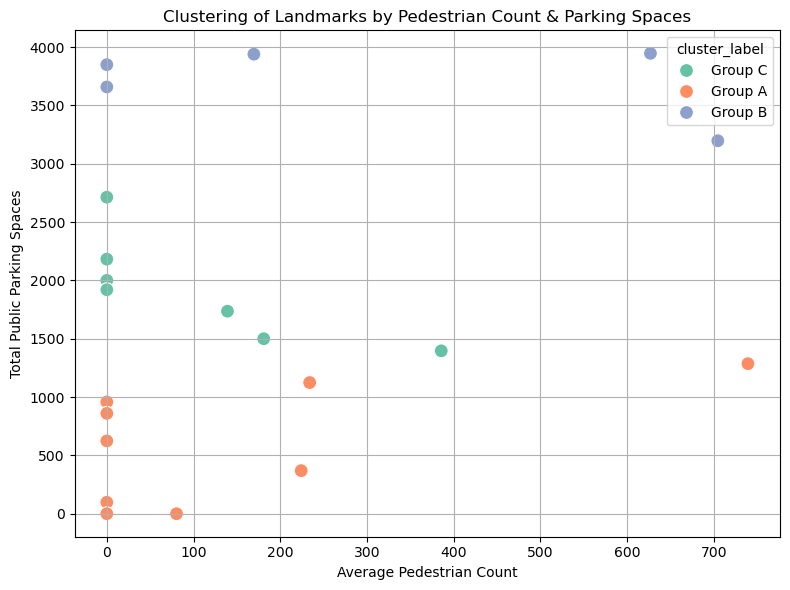

,feature_name,theme,latitude,longitude,nearby_public_carparks,total_public_spaces,parking_addresses,avg_pedestrian_count,peak_hour,pedestrian_display,cluster,cluster_label
0,Carlton Gardens Primary School,Education Centre,-37.802095,144.969406,3,1500,[Melbourne Museum 11 Nicholson Street CARLTON ...,180.95,20,180.95,2,Group C
1,Melbourne Grammar School,Education Centre,-37.834256,144.976285,1,98,[415-421 St Kilda Road MELBOURNE VIC 3004],0.00,no data,no data,0,Group A
2,Epworth Freemasons Hospital : Medical Centre,Health Services,-37.809344,144.982337,3,860,"[94-106 Grey Street EAST MELBOURNE VIC 3002, T...",0.00,no data,no data,0,Group A
3,Royal Womens Hospital,Health Services,-37.798889,144.954897,5,2713,[14-20 Blackwood Street NORTH MELBOURNE VIC 30...,0.00,no data,no data,2,Group C
4,Royal Childrens Hospital,Health Services,-37.794206,144.950048,1,2000,[Royal Childrens Hospital 48-50 Flemington Roa...,0.00,no data,no data,2,Group C


In [71]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate a sample of the landmark_access_summary dataset
# You can replace this with your actual `landmark_access_summary` DataFrame

# Select features for clustering
X = landmark_access_summary[['avg_pedestrian_count', 'total_public_spaces', 'nearby_public_carparks']]

# Fit KMeans with 3 clusters (e.g. Busy, Moderate, Quiet)
kmeans = KMeans(n_clusters=3, random_state=42)
landmark_access_summary['cluster'] = kmeans.fit_predict(X)

# Rename clusters for readability (optional)
landmark_access_summary['cluster_label'] = landmark_access_summary['cluster'].map({0: 'Group A', 1: 'Group B', 2: 'Group C'})

# Plot clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=landmark_access_summary, x='avg_pedestrian_count', y='total_public_spaces', hue='cluster_label', palette='Set2', s=100)
plt.title('Clustering of Landmarks by Pedestrian Count & Parking Spaces')
plt.xlabel('Average Pedestrian Count')
plt.ylabel('Total Public Parking Spaces')
plt.grid(True)
plt.tight_layout()
plt.show()

landmark_access_summary.head()


This scatter plot shows how landmarks in Melbourne are grouped based on average pedestrian count and total public parking spaces nearby.
* **Group A** – These landmarks have low pedestrian traffic but lower parking availability. 
* **Group B** – These places have a lot of parking spaces and high to moderate foot traffic. They are well-supported locations, possibly near major city hubs or transport stations.
* **Group C** – These landmarks have moderate foot traffic and a medium level of parking. They are balanced zones and may not need immediate action.

# Data visualisation
## Interactive Map of landmark accessibility

In [74]:
map_center = [-37.8136, 144.9631]
melb_map = folium.Map(location=map_center, zoom_start=14)

for _, row in landmark_access_summary.iterrows():
    # display 'no data' when there is no nearby sensor
    avg_ped_display = 'no data' if row['avg_pedestrian_count'] == 0 else row['avg_pedestrian_count']

    # peak hour will not display if no  sensor data
    if row['avg_pedestrian_count'] == 0 or row['peak_hour'] == 'no data':
        peak_hour_display = ""
    else:
        peak_hour_display = f"<b>Peak Hour:</b> {row['peak_hour']}:00"

    popup_text = f"""
    <b>{row['feature_name']}</b><br>
    Type: {row['theme']}<br>
    Nearby Public Car Parks: {row['nearby_public_carparks']}<br>
    Total Parking Spaces: {row['total_public_spaces']}<br>
    Avg Pedestrian Count: {avg_ped_display}<br>
    {peak_hour_display}
    """
    
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=folium.Popup(popup_text, max_width=500),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(melb_map)

melb_map


This map shows important public landmarks in Melbourne,like hospitals, schools, and libraries along with useful information about parking and pedestrian activity nearby. Each blue marker represents one of these landmarks. When you click on a marker, a box pops up with these details, which are type, nearby public car parks, total parking spaces, avg pedestrian count, and peak hour.

## Interactive Map of pedestrian sensor locations
We created this map to see where pedestrian sensors are placed in Melbourne. While working on the project, we noticed that some landmarks had no nearby sensor data. So, we built this map to check which areas are covered by sensors and which areas are missing data. Each green dot shows a sensor location, and clicking on it shows the sensor ID.

In [78]:
num_sensors = filtered_pedestrian['location_id'].nunique()
print(f"Number of unique pedestrian sensors: {num_sensors}")

Number of unique pedestrian sensors: 97


In [80]:
unique_sensors = filtered_pedestrian[['location_id', 'latitude', 'longitude']].drop_duplicates()
unique_sensors.head()


,location_id,latitude,longitude
0,25,-37.824018,144.956044
1,71,-37.812358,144.971370
4,44,-37.796987,144.964413
5,143,-37.821728,144.955570
6,40,-37.809993,144.972276


In [82]:
sensor_map = folium.Map(location=[-37.8136, 144.9631], zoom_start=14)

for _, row in unique_sensors.iterrows():
    popup_text = f"Latitude: {row['latitude']:.5f}<br> Longitude: {row['longitude']:.5f}" 
    
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=4,
        popup=folium.Popup(popup_text, max_width=500),
        color='green',
        fill=True
    ).add_to(sensor_map)

sensor_map
